In [1]:
from utils.model import BetaVAE_H
from utils import CelebA
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.transforms import ToTensor, Resize, Compose, Grayscale

import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_size = 64
num_workers = 2
z_dim = 10
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

In [3]:
net = BetaVAE_H(nc=3, z_dim=z_dim, activation=nn.Sigmoid()).to(device)

In [4]:
net.load_state_dict(torch.load('./runs/CelebA/model-100.pt'))

<All keys matched successfully>

In [5]:
print('loading dataset...', end='\r')

train_set = CelebA('./data', split="train", transform=Compose([Resize((image_size, image_size)),ToTensor()]))
#     valid_set = CelebA('./data', split="valid", transform=Compose([Resize((image_size, image_size)),ToTensor()]))
test_set = CelebA('./data', split="test", transform=Compose([Resize((image_size, image_size)),ToTensor()]))
train_loader = DataLoader(train_set,batch_size=32,shuffle=True,num_workers=num_workers,
                        pin_memory=False,drop_last=True)
test_loader = DataLoader(test_set,batch_size=32,shuffle=False,num_workers=num_workers,
                        pin_memory=False,drop_last=True)

In [7]:
female_x, _ = test_loader.dataset.__getitem__(1)
male_x, _ = test_loader.dataset.__getitem__(10)
whitehair_x, _ = test_loader.dataset.__getitem__(19)
random_x, _ = test_loader.dataset.__getitem__(200)

In [8]:
female_x = female_x.to(device)
male_x = male_x.to(device)
whitehair_x = whitehair_x.to(device)
random_x= random_x.to(device)

In [9]:
limit = 3
inter = 2/3

In [10]:
interpolation = torch.arange(-limit, limit+0.1, inter)

In [11]:
z1 = net.encoder(female_x.unsqueeze(0))[0,:z_dim]
z2 = net.encoder(male_x.unsqueeze(0))[0,:z_dim]
z3 = net.encoder(whitehair_x.unsqueeze(0))[0,:z_dim]
z4 = net.encoder(random_x.unsqueeze(0))[0,:z_dim]

In [12]:
Z = {'female':z1, 'male':z2,
     'whitehair':z3, 'random_img':z4}

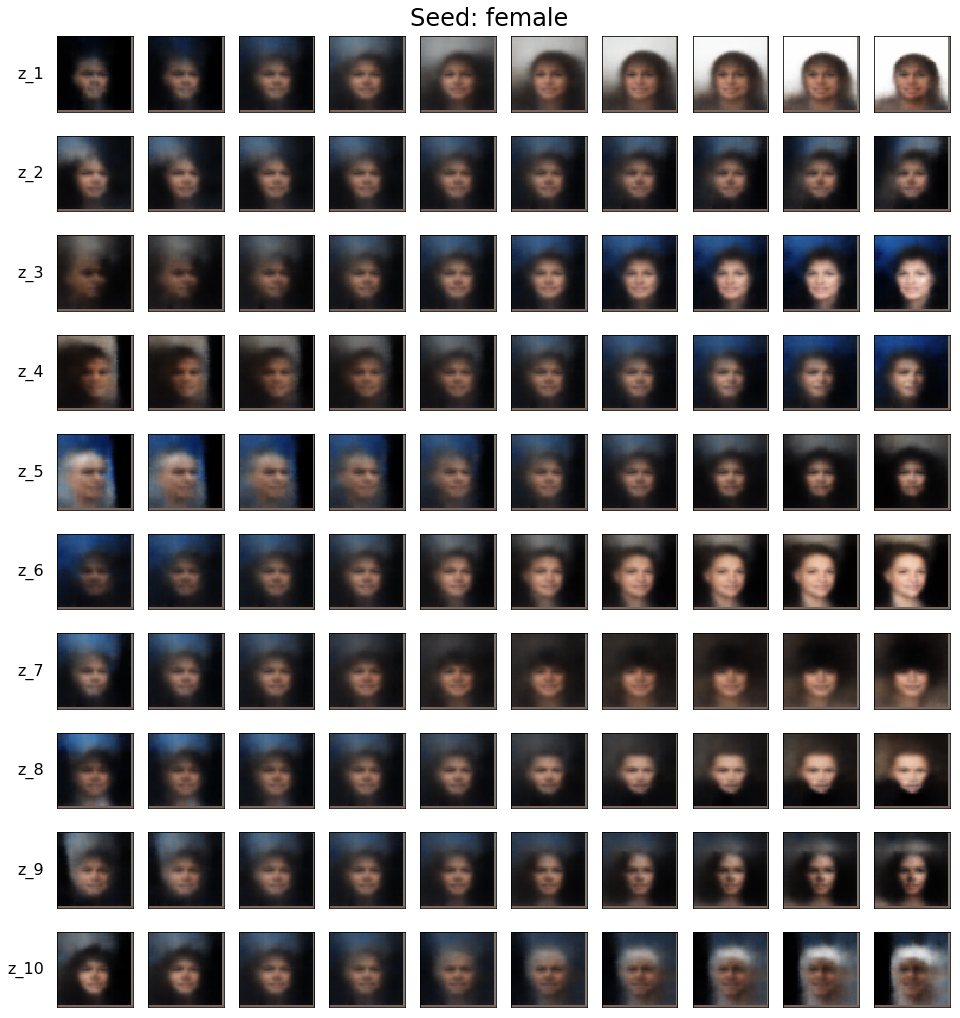

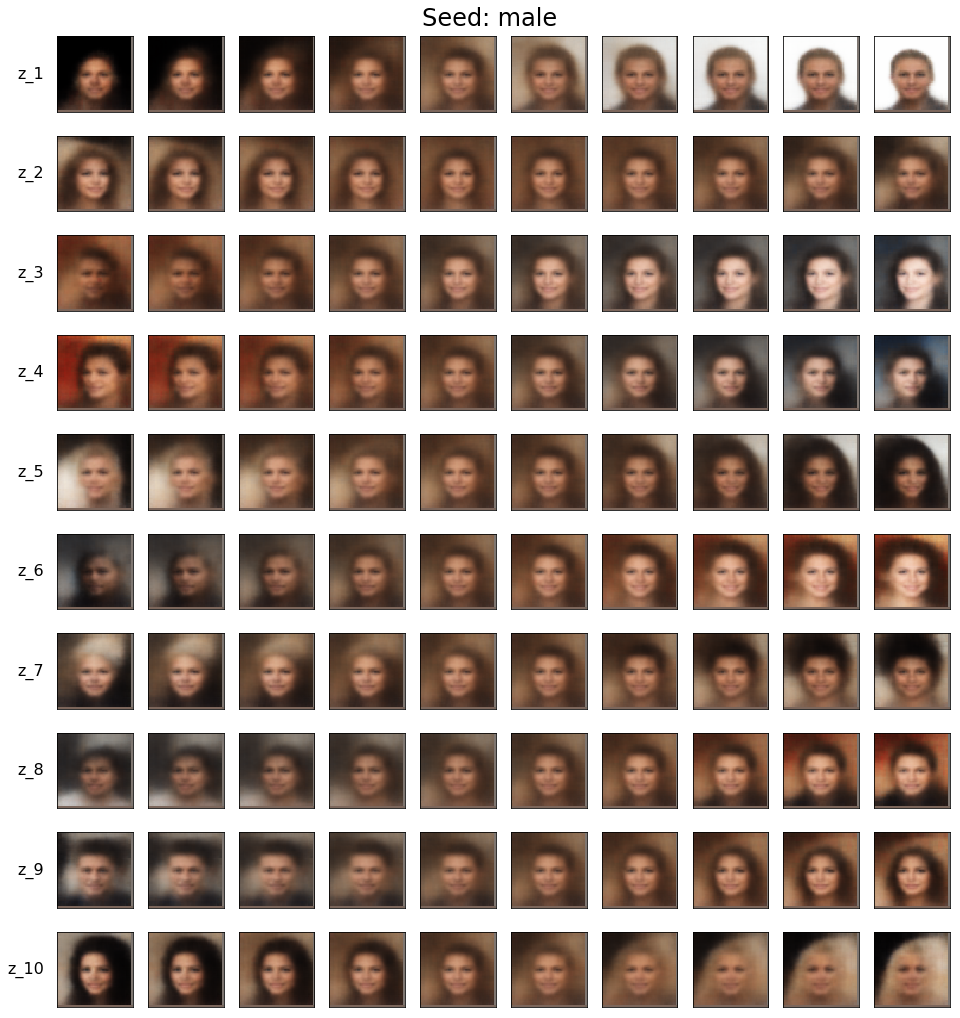

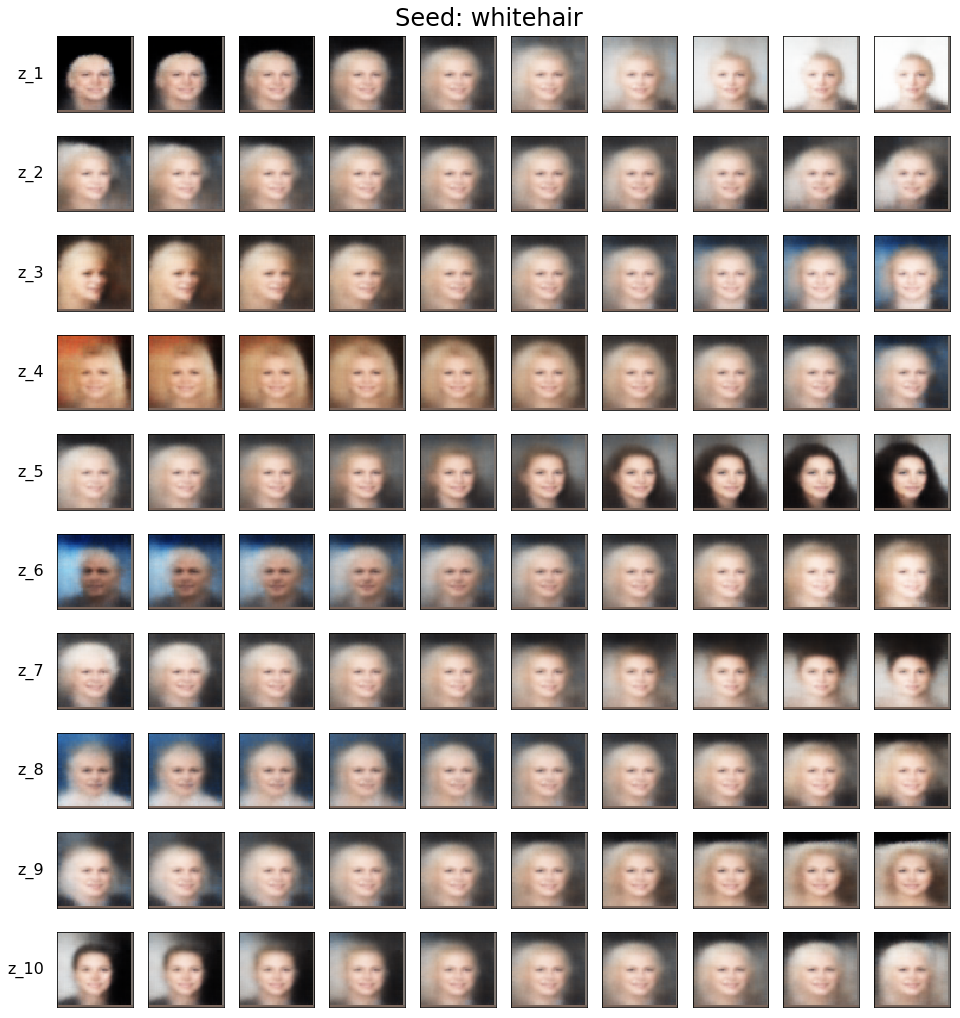

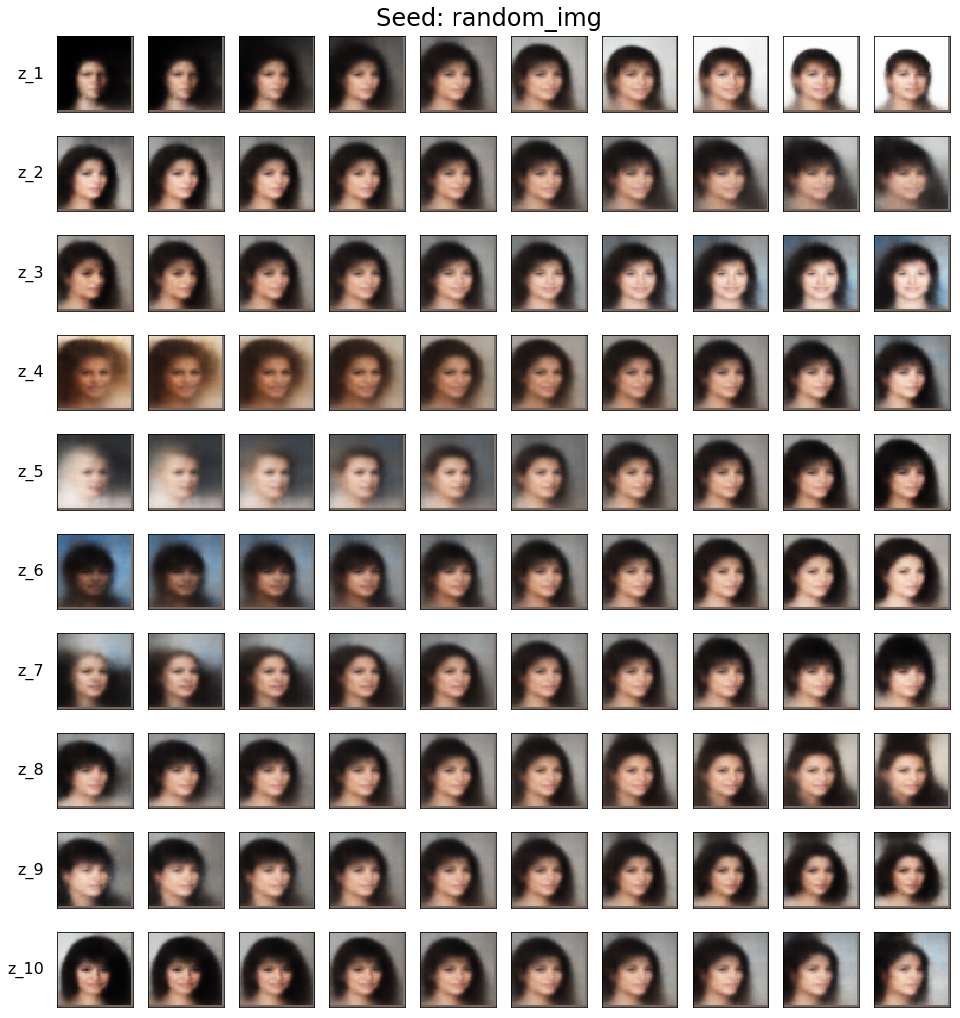

In [13]:
gifs = []
for key in Z.keys():
    z_ori = Z[key]
    samples = []
    for row in range(z_dim):
        z = z_ori.clone()
        for val in interpolation:
            z[row] = val
            sample = torch.sigmoid(net.decoder(z)).data
            samples.append(sample)
    samples = torch.cat(samples, dim=0).cpu()
    
    fig , axes = plt.subplots(10,10, figsize=(16,18))
    fig.suptitle (f'Seed: {key}', y=0.9, size=24)

    for ax, img in zip(axes.flatten(), samples):
        ax.imshow(img.permute(1,2,0))
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        
    # Annotating rows
    rows = [f'z_{num}' for num in range(1,11)]     
    counter = 0
    for idx, ax in enumerate(axes.flatten()):
        if idx%10 == 0:
            ax.annotate(rows[counter], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points',
                        size=16, ha='right', va='center')  
            counter += 1
